In [1]:
from dataToDictionnary import *
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import time

# Load the prices data for 2 assets

exchanges = ['binance']
pairs = ['ETH/USDT','REN/USDT']
durations = ['3m']

data = dataToDico(pairs, durations, exchanges)
df=pd.DataFrame.from_dict(data, orient='index')

df = df.transpose()
df=df.dropna()
df['time'] = pd.to_datetime(df['time'],unit='ms')
df = df[df[pairs[0]]!=0]
df = df[df[pairs[1]]!=0]
df = df.reset_index()
print(df.head())
print(len(df))
df.set_index('time')

print(df.info())

<class 'list'>
<class 'list'>
   index                time  ETH/USDT  REN/USDT
0      4 2020-01-10 22:15:00    142.01   0.04511
1      5 2020-01-10 22:18:00    142.43   0.04545
2      6 2020-01-10 22:21:00    142.38   0.04545
3      7 2020-01-10 22:24:00    142.46   0.04545
4      8 2020-01-10 22:27:00    142.49   0.04545
175078
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175078 entries, 0 to 175077
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   index     175078 non-null  int64         
 1   time      175078 non-null  datetime64[ns]
 2   ETH/USDT  175078 non-null  float64       
 3   REN/USDT  175078 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 5.3 MB
None


In [2]:
from statsmodels.regression.rolling import RollingOLS
"""Creates a hedge ratio between the two pairs by calculating
    a rolling linear regression with a defined lookback period. This
    is then used to create a z-score of the 'spread' between the two
    pairs based on a linear combination of the two."""
def calculate_spread_zscore(df,lookback=100):
    print("Fitting the rolling Linear Regression...")
    y=df[pairs[0]]
    x=df[pairs[1]]

    model = RollingOLS(x,y, lookback).fit()

    # Construct the hedge ratio and eliminate the first 
    # lookback-length empty/NaN period
    df['hedge_ratio'] = model.params
    df = df.dropna()

    # Create the spread and then a z-score of the spread
    print("Creating the spread/zscore columns...")
    rollingMean = 7500
    df['spread'] = df[pairs[0]] - df['hedge_ratio']*df[pairs[1]]
    df['zscore'] = (df['spread'] - df['spread'].rolling(rollingMean).mean()/df['spread'].rolling(rollingMean).std())
    return df


In [3]:
# mr_spy_iwm.py

def create_long_short_market_signals(df, 
                                     z_entry_threshold=2.0, 
                                     z_exit_threshold=1.0):

    

    # Calculate when to be long, short and when to exit
    df['longs'] = (df['zscore'] <= -z_entry_threshold)*1.0
    df['shorts'] = (df['zscore'] >= z_entry_threshold)*1.0
    df['exits'] = (np.abs(df['zscore']) <= z_exit_threshold)*1.0
    # These signals are needed because we need to propagate a
    # position forward, i.e. we need to stay long if the zscore    
    # threshold is less than z_entry_threshold by still greater
    # than z_exit_threshold, and vice versa for shorts.
    df['long_market'] = 0.0
    df['short_market'] = 0.0

    # These variables track whether to be long or short while
    # iterating through the bars
    long_market = 0
    short_market = 0

    # Calculates when to actually be "in" the market, i.e. to have a
    # long or short position, as well as when not to be.
    # Since this is using iterrows to loop over a dataframe, it will
    # be significantly less efficient than a vectorised operation,
    # i.e. slow!
    print("Calculating when to be in the market (long and short)...")
    for i, b in (df.iterrows()):
        # Calculate longs
        if b['longs'] == 1.0:
            long_market = 1            
        # Calculate shorts
        if b['shorts'] == 1.0:
            short_market = 1
        # Calculate exists
        if b['exits'] == 1.0:
            long_market = 0
            short_market = 0
        # This directly assigns a 1 or 0 to the long_market/short_market
        # columns, such that the strategy knows when to actually stay in!
        #df.loc[i]['long_market'] = long_market
        df.at[i, 'long_market'] = long_market
        df.at[i, 'short_market'] = short_market
    return df

In [4]:
# mr_spy_iwm.py

def create_portfolio_returns(df):
    """Creates a portfolio pandas DataFrame which keeps track of
    the account equity and ultimately generates an equity curve.
    This can be used to generate drawdown and risk/reward ratios."""
    
    
    print("Constructing a portfolio...")
    portfolio = pd.DataFrame(index=df.index)
    portfolio['positions'] = df['long_market'] - df['short_market']
    portfolio[pairs[0]] = -1.0 * df[pairs[0]] * portfolio['positions']
    portfolio[pairs[1]] = df[pairs[1]] * portfolio['positions']
    portfolio['total'] = portfolio[pairs[0]] + portfolio[pairs[1]]

    # Construct a percentage returns stream and eliminate all 
    # of the NaN and -inf/+inf cells
    print("Constructing the equity curve...")
    portfolio['returns'] = portfolio['total'].pct_change()
    portfolio['returns'].fillna(0.0, inplace=True)
    portfolio['returns'].replace([np.inf, -np.inf], 0.0, inplace=True)
    portfolio['returns'].replace(-1.0, 0.0, inplace=True)

    # Calculate the full equity curve
    portfolio['returns'] = (portfolio['returns'] + 1.0).cumprod()

    return portfolio

Calculating lookback=50...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Constructing the equity curve...
Calculating lookback=60...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Constructing the equity curve...
Calculating lookback=70...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Constructing the equity curve...
Calculating lookback=80...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Constructing the equity curve...
Calculating lookback=90...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns..

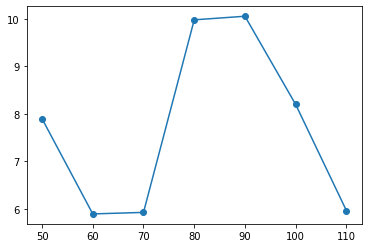

'\ndf[\'buyAndHold\']=df[pairs[0]]/df[pairs[0]][lookback]\nprint(\'return for buy and hold strategy : \', df.iloc[-1][\'buyAndHold\']*100, \'%\')\n\nprint("Plotting the performance charts...")\nfig = plt.figure()\nfig.patch.set_facecolor(\'white\')\n\nax1 = fig.add_subplot(211,  ylabel=\'%s growth (%%)\' % pairs[0])\n(df[pairs[0]].pct_change()+1.0).cumprod().plot(ax=ax1, color=\'r\', lw=2.)\nax2 = fig.add_subplot(212, ylabel=\'Portfolio value growth (%%)\')\nportfolio[\'returns\'].plot(ax=ax2, lw=2.)\nfig.show()\n'

In [5]:
lookbacks = range(50, 120, 10)
returns = []

# Adjust lookback period from 50 to 200 in increments
# of 10 in order to produce sensitivities
for lb in lookbacks: 
    print("Calculating lookback=%s..." % lb)
    df = calculate_spread_zscore(df, lookback=lb)
    df = create_long_short_market_signals(df, 
                                            z_entry_threshold=2.0, 
                                            z_exit_threshold=1.0)
    portfolio = create_portfolio_returns(df)
    returns.append(portfolio.iloc[-1]['returns'])

print("Plot the lookback-performance scatterchart...")
plt.plot(lookbacks, returns, '-o')
#plt.ylabel('returns')
#plt.xlabel('lookbacks')
plt.show()
'''
df['buyAndHold']=df[pairs[0]]/df[pairs[0]][lookback]
print('return for buy and hold strategy : ', df.iloc[-1]['buyAndHold']*100, '%')

print("Plotting the performance charts...")
fig = plt.figure()
fig.patch.set_facecolor('white')

ax1 = fig.add_subplot(211,  ylabel='%s growth (%%)' % pairs[0])
(df[pairs[0]].pct_change()+1.0).cumprod().plot(ax=ax1, color='r', lw=2.)
ax2 = fig.add_subplot(212, ylabel='Portfolio value growth (%%)')
portfolio['returns'].plot(ax=ax2, lw=2.)
fig.show()
'''


In [8]:
data = dataToDico(pairs, durations, exchanges)
df=pd.DataFrame.from_dict(data, orient='index')

df = df.transpose()
df=df.dropna()
df['time'] = pd.to_datetime(df['time'],unit='ms')
df = df[df[pairs[0]]!=0]
df = df[df[pairs[1]]!=0]
df = df.reset_index()
print(df.head())
print(len(df))
df.set_index('time')

<class 'list'>
<class 'list'>
   index                time  ETH/USDT  REN/USDT
0      4 2020-01-10 22:15:00    142.01   0.04511
1      5 2020-01-10 22:18:00    142.43   0.04545
2      6 2020-01-10 22:21:00    142.38   0.04545
3      7 2020-01-10 22:24:00    142.46   0.04545
4      8 2020-01-10 22:27:00    142.49   0.04545
175078


,index,ETH/USDT,REN/USDT
time,,,
2020-01-10 22:15:00,4,142.01,0.04511
2020-01-10 22:18:00,5,142.43,0.04545
2020-01-10 22:21:00,6,142.38,0.04545
2020-01-10 22:24:00,7,142.46,0.04545
2020-01-10 22:27:00,8,142.49,0.04545
...,...,...,...
2021-01-10 12:45:00,175077,1283.39,0.41592
2021-01-10 12:48:00,175078,1292.93,0.42051
2021-01-10 12:51:00,175079,1292.57,0.41992


Fitting the rolling Linear Regression...
Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Constructing the equity curve...
return for mean reversion pairs strategy :  588.5045647392632 %


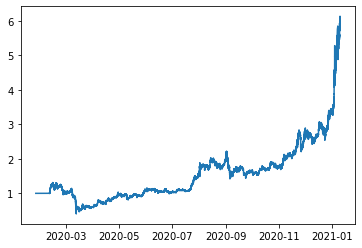

return for buy and hold strategy :  788.8067000855849 %


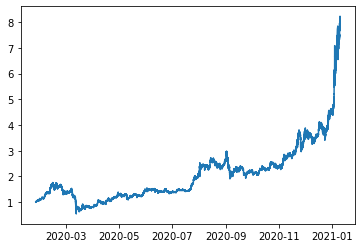

In [9]:
#seems that optimal lookback  is 80
# so we visualize returns for lookback = 80
lookback = 7500
df = calculate_spread_zscore(df, lookback)
    
df = create_long_short_market_signals(df, 1.0, 2.0)
#print(df.loc[df['long_market']==1].count())
portfolio = create_portfolio_returns(df)
print('return for mean reversion pairs strategy : ',portfolio.iloc[-1]['returns']*100, '%')
df['buyAndHold']=df[pairs[0]]/df[pairs[0]][lookback]

plt.plot(df['time'], portfolio['returns'])
plt.title = ('returns for mean reversion pairs')
plt.ylabel = ('return')
#fig.autofmt_xdate()
plt.show()

print('return for buy and hold strategy : ', df.iloc[-1]['buyAndHold']*100, '%')
plt.figure()
plt.plot(df['time'], df[pairs[0]]/df[pairs[0]][7500])
plt.title = ('returns for buy and hold')
plt.ylabel = ('return')
plt.show()